# Un problème en mécanique quantique numérique: Le potentiel de Lennard-Jones avec numpy et SciPy

On va numériquement étudier l'équation de Schrödinger indpépendante du temps en une dimension avec un potentiel de Lennard-Jones. Ce potentiel décrit, en trois dimensions, les interactions entre des molecules de manière phénoménologique et approximative. Il est donné par $$V(x)=\epsilon\,\left(\left(\frac{x_0}{x}\right)^{12}-2\,\left(\frac{x_0}{x}\right)^6\right)\,.$$ On ne regarde que les $x$ positifs. Par inspection on déduit que
* $V(x)\,\rightarrow\,\infty\;$ lorsque $x\,\rightarrow\,0$ et $V(x)\,\rightarrow\,0\;$ lorsque $x\,\rightarrow\,\infty$
* il y a un minimum global à $x=x_0$ avec énergie $-\epsilon$

Tracons d'abord le potentiel pour plusieurs valeurs de $\epsilon$ et $x_0=1$ entre $x=0.8$ et $x=2$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

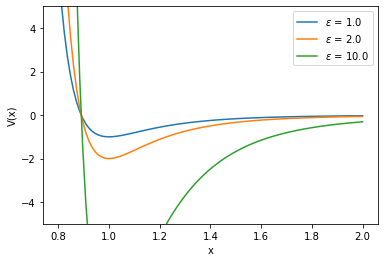

In [2]:
x0 = 1.
def V(x, epsilon):
    return epsilon * ((x0 / x)**12 - 2 * (x0 / x)**6)

xpoints = np.linspace(.8, 2, 100)
for epsilon in [1., 2., 10.]:
    plt.plot(xpoints, V(xpoints, epsilon), label=r'$\epsilon$ = ' + str(epsilon))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.ylim(-5, 5)
plt.legend()
plt.show()

### La discrétisation de l'hamiltonien

L'équation de Schrödinger indépendante du temps est $$H\psi(x)=E\psi(x)\,\qquad\qquad\text{avec } H=\left(-\frac{\hbar^2}{2m}\frac{d^2}{dx^2}+V(x)\right)\,.$$ 

Notre premier objectif sera le calcul numérique des énergies $E$ des états liés, alors les valeurs propres négatives de l'opérateur $H$. Mais cet opérateur agît sur un espace vectoriel de dimension infinie (l'espace de Hilbert du problème). Pour le traitement numérique il faut *discrétiser* (prendre l'approximation d'un espace d'états de dimension finie), ce qui transforme l'opérateur différentiel linéaire $H$ en opérateur en *matrice* $(N+1)\times (N+1)$. Plus $N$ est grand, plus notre approximation sera précise.

De plus, au lieu de considérer une fonction d'onde $\psi(x)$ sur $\mathbb{R}_+$ on va se limiter à un domaine de solutions fini. En fait on s'attend que $\psi(x)\,\rightarrow\,0$ pour $x$ suffisamment grand pour des modes normalisables, alors on résoudra le système pour $x\in[0, x_{\text{max}}]$ en choisissant $x_{\text{max}}$ suffisamment grand. Plus $x_{\text{max}}$ est grand, plus notre approximation sera précise.

Mais l'espace de fonctions d'onde sur $[0, x_{\text{max}}]$ est toujours de dimension infinie. Alors on regardera un ensemble fini de $N+1$ valeurs de fonction $\psi(na)$ (avec $n=0\ldots N$), où
$$
a = \frac{x_{\text{max}}}{N}\,.
$$

Qu'est-ce que la discrétisation de l'opérateur différentiel $\frac{d^2}{dx^2}$? On rappelle le développement limité d'une fonction $f(x)$,
$$\begin{split}f(x+a)=&\;f(x)+a\,f'(x)+\frac{1}{2} a^2\,f''(x)+\frac{1}{6}a^3\,f'''(x)+{\cal O}(a^4),\\ f(x-a)=&\;f(x)-a\,f'(x)+\frac{1}{2} a^2\,f''(x)-\frac{1}{6}a^3\,f'''(x)+{\cal O}(a^4)\,.\end{split}$$
En prenant la somme de ces deux équations, les puissances impaires de $a$ se suppriment et on arrive à
$$f(x+a)+f(x-a)=2\,f(x)+a^2\,f''(x)+{\cal O}(a^4)\;\Rightarrow\;f''(x)=\frac{f(x+a)+f(x-a)-2\,f(x)}{a^2}+{\cal O}(a^2)\,.$$
On conclut que, pour $a$ suffisamment petit (c.à.d. $N$ suffisamment grand), on peut approximer
$$
\frac{d^2}{dx^2}\psi(x)\approx \frac{\psi(x+a)+\psi(x-a)-2\,\psi(x)}{a^2}\,.
$$
Si on met tous les valeurs de la fonction d'onde $\psi(na)$ dans un vecteur de colonne $\Psi$,
$$
\Psi=\left(\begin{array}{c}\psi(0) \\ \psi(a) \\ \psi(2a) \\ \vdots\\ \psi(Na)\end{array}\right)
$$
alors l'action de l'opérateur $\frac{d^2}{dx^2}$ devient une multiplication matricielle:
$$
\frac{d^2}{dx^2}\psi\approx \frac{1}{a^2}\left(\begin{array}{ccccc}\ddots &&&&\\ 1 & -2 & 1 && \\ &1&-2&1& \\ &&1&-2&1 \\ &&&&\ddots\end{array}\right)\Psi\,.
$$
D'où la partie cinétique du hamiltonien peut s'écrire approximativement 
$$
\frac{\hbar^2}{2m}\frac{d^2}{dx^2}\approx \frac{\hbar^2}{2ma^2}\,M\,,
%\left(\begin{array}{ccccc}\ddots &&&&\\ 1 & -2 & 1 && \\ &1&-2&1& \\ &&1&-2&1 \\ &&&&\ddots\end{array}\right)\,.
$$
$M$ étant une matrice $(N+1)\times(N+1)$ avec des $-2$ sur la diagonale principale, des $1$ aux côtés de la diagonale principale, et des $0$ ailleurs. Construisons cette matrice pour $N=10$:

In [3]:
# numpy.identity(n) va construire la matrice d'identité n x n
# numpy.diag(v, k=0) va construire une matrice avec le vecteur v sur la k-ème diagonale, avec k=0 la principale.
def matriceM(N):
    M = -2 * np.identity(N + 1)  # la matrice -2 I de dimension (N+1)x(N+1)
    ones = np.ones(N)            # le tableau [1, 1,... 1] de dimension N
    M += np.diag(ones, -1)
    M += np.diag(ones, 1)
    return M

print(matriceM(10))

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


La représentation discrète de la partie $V(x)$ du hamiltonien est plus simple: C'est une matrice diagonale avec les entrées diagonales $V(0),\,V(a),\,V(2a) \ldots V(Na)$. Le seul problème est que $V(0)$ diverge, alors on posera $V(0)=$ "infini" (= un très grand nombre) à la main. 

Nous sommes maintenant en mesure de construire le hamiltonien complet. En unités où $\hbar=1$ et $m=1$:

In [4]:
def hamiltonien(epsilon, xmax, N):
    a = xmax / N
    xn = np.linspace(0, xmax, N + 1)
    with np.errstate(divide='ignore', invalid='ignore'): # sinon Python va se plaindre car pour V(0) on divise par 0
        Vxn = V(xn, epsilon)     
    Vxn[0] = 1.E8 # "infini" = une constante >> la plus grande autre échelle du problème

    H = -1 / (2 * a**2) * matriceM(N) + np.diag(Vxn)
    return H

### Détermier l'état fondamental d'un système avec un seul état lié

Pour trouver les valeurs propres de cette matrice, on se servira de la méthode **scipy.linalg.eig(a)**. Cette méthode prend une matrice carrée comme argument et renvoie un tableau 1-dimensionnel qui contient les valeurs propres, ainsi qu'un tableau 2-dimensionnel dont les colonnes contiennent les composantes des vecteurs propres normalisés. Pour les valeurs des paramètres, nous choisirons $\epsilon=10$, $x_{\text{max}}=5$ et $N=100$.

In [5]:
import scipy.linalg
H = hamiltonien(10, 5, 100)
E, vecteurspropres = scipy.linalg.eig(H)  # fonction qui renvoie les valeurs propres et vecteurs propres normalisés
                                          # (ces derniers sont les colonnes de la matrice 'vecteurspropres')
print("Énergies:")
print(np.sort(E))

Énergies:
[-1.38692455e+00+0.j  4.00475323e-01+0.j  1.54646685e+00+0.j
  3.32372791e+00+0.j  5.68215786e+00+0.j  8.59848071e+00+0.j
  1.20576262e+01+0.j  1.60475003e+01+0.j  2.05572262e+01+0.j
  2.55764159e+01+0.j  3.10948159e+01+0.j  3.71021121e+01+0.j
  4.35878129e+01+0.j  5.05411766e+01+0.j  5.79511628e+01+0.j
  6.58064023e+01+0.j  7.40951762e+01+0.j  8.28054046e+01+0.j
  9.19246396e+01+0.j  1.01440064e+02+0.j  1.11338492e+02+0.j
  1.21606375e+02+0.j  1.32229806e+02+0.j  1.43194527e+02+0.j
  1.54485944e+02+0.j  1.66089132e+02+0.j  1.77988849e+02+0.j
  1.90169551e+02+0.j  2.02615404e+02+0.j  2.15310299e+02+0.j
  2.28237870e+02+0.j  2.41381503e+02+0.j  2.54724363e+02+0.j
  2.68249399e+02+0.j  2.81939373e+02+0.j  2.95776868e+02+0.j
  3.09744315e+02+0.j  3.23824001e+02+0.j  3.37998100e+02+0.j
  3.52248680e+02+0.j  3.66557730e+02+0.j  3.80907178e+02+0.j
  3.95278906e+02+0.j  4.09654774e+02+0.j  4.24016640e+02+0.j
  4.38346375e+02+0.j  4.52625887e+02+0.j  4.66837138e+02+0.j
  4.80962165e+

Il ne faut pas trop regarder les valeurs propres positives. En fait pour les états de diffusion on s'attend un spectre continu, la quantification des valeurs propres ici est un artefact numérique.

Par contre il semble qu'il y a un état lié avec énergie $E=-0.13869\ldots$ en nos unités. Le vecteur propre correspondant est la fonction d'onde $\psi_0(x)$ de l'état fondamental, stocké dans la colonne du même indice de la matrice **vecteurspropres**. On trace $\psi_0$:

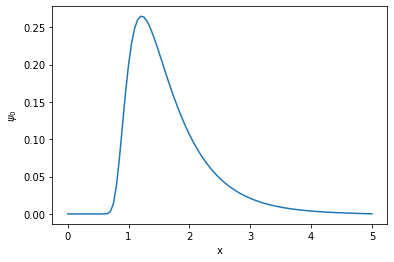

In [6]:
n0 = np.argmin(E)             # donne l'indice de l'élément minimal de E = l'énergie de l'état fondamental
psi0 = vecteurspropres[:, n0] # la fonction d'onde de l'état fondamental est la colonne correspondante à cet indice
x = np.linspace(0, 5, 101)
plt.plot(x, np.abs(psi0))
plt.xlabel("x")
plt.ylabel(r"$\psi_0$")
plt.show()

Est-ce qu'on peut faire confiance à ces résultats? Pour le savoir, on repète le calcul avec 
* un plus grand nombre $N$ de points
* un intervalle $[0,x_{\text{max}}]$ plus large
* un plus grand nombre de points et un intervalle plus large.

À noter que les vecteurs propres calculés par **scipy.linalg.eig** sont normalisés par la condition
$$
\sum_{n=0}^N |\psi(n\,a)|^2=1
$$
tant que la bonne normalisation de la fonction d'onde nécessite
$$
1\stackrel{!}{=} \int |\psi(x)|^2\,dx\approx a\sum_{n=0}^N |\psi(n\,a)|^2\,.
$$
Pour avoir des fonctions d'onde avec la bonne normalisation relative, il faut alors diviser par $\sqrt{a}$.

Regardons ce qui change si on augmente $N$ et $x_{\text{max}}$:

Énergie de l'état fondamental pour xmax =  5 , N =  200 : (-1.3760710461954635+0j)
Énergie de l'état fondamental pour xmax =  5 , N =  500 : (-1.3730573467721972+0j)
Énergie de l'état fondamental pour xmax =  10 , N =  200 : (-1.3869405195656397+0j)
Énergie de l'état fondamental pour xmax =  10 , N =  500 : (-1.3747967271601738+0j)


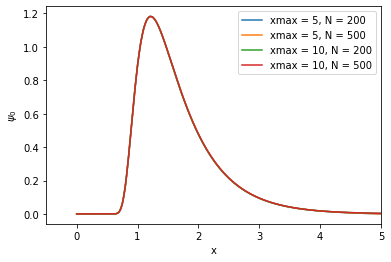

In [7]:
for xmax in [5, 10]:
    for N in [200, 500]:
        H = hamiltonien(10, xmax, N)
        E, vecteurspropres = scipy.linalg.eig(H)
        print("Énergie de l'état fondamental pour xmax = ", xmax, ", N = ", N, ":",  E.min())
        n0 = np.argmin(E)               # l'indice de l'élément minimal de E, qui correspond à l'état fondamental
        psi0 = vecteurspropres[:, n0]   # la fonction d'onde correspondante
        norm = np.sqrt(N / xmax)        # facteur de normalisation
        x = np.linspace(0, xmax, N+1)   
        plt.plot(x, norm * np.abs(psi0), label = "xmax = " + str(xmax) + ", N = " + str(N)) 
plt.xlim(right=5)
plt.xlabel("x")
plt.ylabel(r"$\psi_0$")
plt.legend()
plt.show()

Il semble que l'énergie est bien déterminée par notre procédure (avec une précision relative de $\lesssim$ 1%). Les fonctions d'onde s'accordent bien également; en fait elles ne sont presque pas discernables par œil dans le graphique.

### Plusieurs états liés

On va maintenant augmenter la profondeur du potentiel pour trouver plus qu'un état lié:

État lié trouvé avec énergie (-62.746063429477545+0j)
État lié trouvé avec énergie (-17.98958162832878+0j)
État lié trouvé avec énergie (-1.816106350970557+0j)


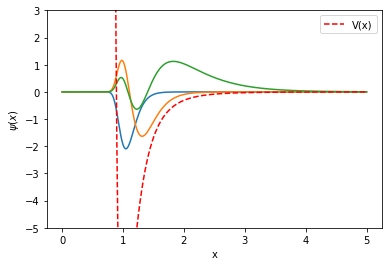

In [8]:
epsilon = 100.
N = 500
xmax = 10.
H = hamiltonien(epsilon, xmax, N) 
norm = np.sqrt(N / xmax)
E, vecteurspropres = scipy.linalg.eig(H)
fonctionsdonde = []   # pour enregistrer les coefficients des vecteurs propres
for e in E[E < 0]:    # identifier les énergies des états liés = les valeurs propres négatives
    print("État lié trouvé avec énergie", e)
    fonctionsdonde.append(norm * vecteurspropres[:, np.where(E==e)].flatten())  
x = np.linspace(0, 5, 251)    # tracer les fonctions d'onde sur l'intervalle [0, 5] = la première moitié des points calculés
for psi in fonctionsdonde:   
    plt.plot(x, psi[:251])
xx = np.linspace(0.8, 5, 300) # dans le même graphique, tracer aussi le potentiel entre x = 0.8 et x = 5
plt.plot(xx, 0.1*V(xx, epsilon), 'r--', label="V(x)")  # (unités arbitraires, facteur 0.1 pour mieux voir la courbe)
plt.xlabel("x")
plt.ylabel(r"$\psi(x)$")
plt.ylim([-5, 3])
plt.legend()
plt.show()

On s'aperçoit de trois états liés avec les fonctions d'onde à $0$, $1$ et $2$ nœuds. 



### Comparaison avec l'approximation harmonique

Peut-on approximer le potentiel aux alentours de son minimum par un oscillateur harmonique? On note que, après un développement limité,
$$
V(x_0+x)=V(x_0)+x\,V'(x_0)+\frac{1}{2} x^2 V''(x_0)+{\cal O}(x^3)
$$
où $V'(x_0)=0$ car il s'agît d'un minimum et $V(x_0)=-\epsilon$ n'est qu'une constante. Le calcul de $V''(x_0)$ donne 
$$V''(x_0)=72\,\frac{\epsilon}{x_0^2}\,.$$
Si les termes d'ordre $\geq x^3$ sont négligéables, en comparant avec le potentiel habituel de l'oscillateur harmonique
$$
V_{\text{OH}}=\frac{m\omega^2}{2}x^2
$$
on déduit qu'il faut identifier 
$$\omega=\frac{6}{x_0}\,\sqrt{\frac{2\,\epsilon}{m}}\,.$$
Cependant, en juste regardant les courbes des deux potentiels on s'attend que l'approximation ne va pas être très bonne:

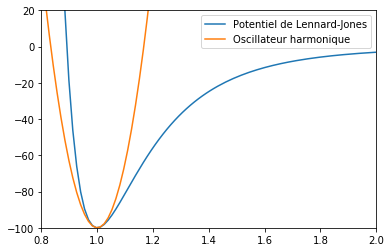

In [9]:
omega = 6 / x0 * np.sqrt(2 * epsilon)
plt.plot(xx, V(xx, epsilon), label="Potentiel de Lennard-Jones")
plt.plot(xx, omega**2 / 2 * (xx - x0)**2 - epsilon, label = "Oscillateur harmonique")
plt.xlim(0.8, 2.0)
plt.ylim(-100, 20)
plt.legend()
plt.show()

Les énergies des états liés de l'oscillateur harmonique sont données par la formule bien connue
$$
E_n=\hbar\omega\left(n+\frac{1}{2}\right)\,,\qquad n\geq 0
$$
de laquelle il faut soustraire $\epsilon$ pour arriver à la même normalisation du minimum que pour notre potentiel de Lennard-Jones. Alors:

In [10]:
print("Premiers niveaux d'énergie d'un oscillateur harmonique:")
for n in range(3):
    print(omega * (n + 0.5) - epsilon)

Premiers niveaux d'énergie d'un oscillateur harmonique:
-57.57359312880715
27.27922061357856
112.13203435596427


Visiblement l'approximation est tout à fait assez mauxaise: l'énergie de l'état fondamental est réproduite à 10% près, mais les autres deux états liés sont complètement faux. 

On peut également comparer les fonctions d'onde. Les fonctions propres de l'oscillateur harmonique sont données par
$$
h_n(x)=N_n\,\exp\left(-\frac{m\omega x^2}{2\hbar}\right)\,H_n\left(\sqrt{\frac{m\omega}{\hbar}}\,x\right)
$$
où $N_n=\left(2^n\,n!\right)^{-1/2}\left(\frac{m\omega}{\pi\hbar}\right)^{1/4}$ est un facteur de normalisation et $H_n$ est le $n$-ème *polynôme d'Hermite*, défini dans la bibliothèque des fonctions mathématiques spéciales **scipy.special**. On définit alors

In [11]:
import scipy.special
# La fonction scipy.special.factorial donne la factorielle.
# La fonction scipy.special.hermite(n) donne le n-ème polynôme de Hermite H_n.
def h(x, n):
    Nn = (2**n * scipy.special.factorial(n))**(-1/2) * (omega / np.pi)**(1/4)
    return Nn * np.exp(- omega * x**2 / 2) * scipy.special.hermite(n)(np.sqrt(omega) * x)

Avant de les utiliser, vérifions numériquement que les fonctions $h_n(x)$ ainsi définies sont bien normalisées: il faut que $$\int_{-\infty}^\infty |h_n(x)|^2\,dx = 1\,.$$ Avec la fonction **scipy.integrate.quad(f, a, b)** on peut calculer des intégrales numériques, même impropres. Elle renverra deux nombres: une estimation numérique de l'intégrale de la fonction $f$ entre $a$ et $b$, et une estimation de l'erreur numérique.

In [12]:
import scipy.integrate
for n in range(3):
    def integrande(x):
        return h(x, n)**2
    print("Normalisation de h" + str(n) + ":", scipy.integrate.quad(integrande, -np.inf, np.inf))

Normalisation de h0: (0.9999999999999999, 6.4277834224874775e-12)
Normalisation de h1: (1.0000000000000002, 1.113001882869133e-09)
Normalisation de h2: (1.0000000000000002, 3.2288531904171224e-09)


La normalisation est alors correcte dans les limites de la précision numérique dont nous avons besoin. 

Maintenant on peut comparer les deux fonctions d'onde pour les deux états fondamentaux, celui de l'oscillateur harmonique et celui du potentiel de Lennard-Jones. (On rappelle que le signe de la fonction d'onde n'est pas physique, alors il faut éventuellement multiplier par $-1$ pour mieux pouvoir comparer.)

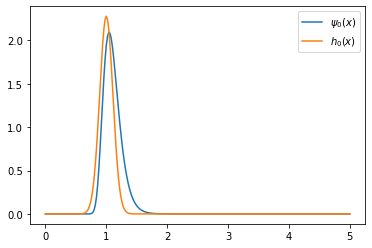

In [16]:
plt.plot(x, -fonctionsdonde[0][:251], label=r"$\psi_0(x)$")
h0 = h(x - x0, 0)
plt.plot(x, h0 , label=r"$h_0(x)$")
plt.legend()
plt.show()

Pour l'état fondamental le profil est au moins qualitativement similaire, même si la fonction d'onde de l'oscillateur harmonique est légèrement décalé vers la gauche et moins large. Par contre les états excités ne se ressemblent pas beaucoup:

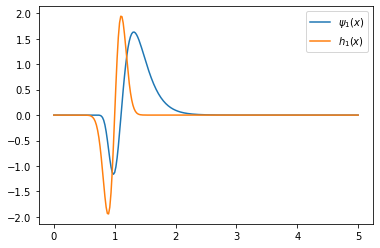

In [18]:
plt.plot(x, -fonctionsdonde[1][:251], label=r"$\psi_1(x)$")
h1 = h(x - x0, 1)
plt.plot(x, h1, label=r"$h_1(x)$")
plt.legend()
plt.show()

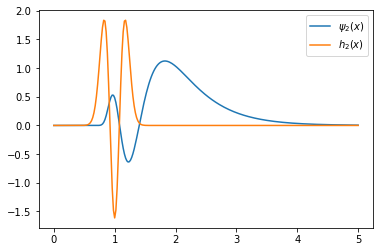

In [19]:
plt.plot(x, fonctionsdonde[2][:251], label=r"$\psi_2(x)$")
h2 = h(x - x0, 2)
plt.plot(x, h2, label=r"$h_2(x)$")
plt.legend()
plt.show()